In [45]:
#import libraries
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


#specify csv file-path
data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/store-sales-time-series-forecasting')

#book_sales - dataframe 
book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

#book_sales - time dummy 
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

#ar - dataframe
ar = pd.read_csv(data_dir / 'ar.csv')

#store_sales - dataframe
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
#pre-process store_sales - dataframe
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']


--------------------------------------------------------------------------------
One advantage linear regression has over more complicated algorithms is that the models it creates are *explainable* -- it's easy to interpret what contribution each feature makes to the predictions. In the model `target = weight * feature + bias`, the `weight` tells us by how much the `target` changes on average for each unit of change in the `feature`.


## **Linear Regression ("book_sales"-dataframe):**

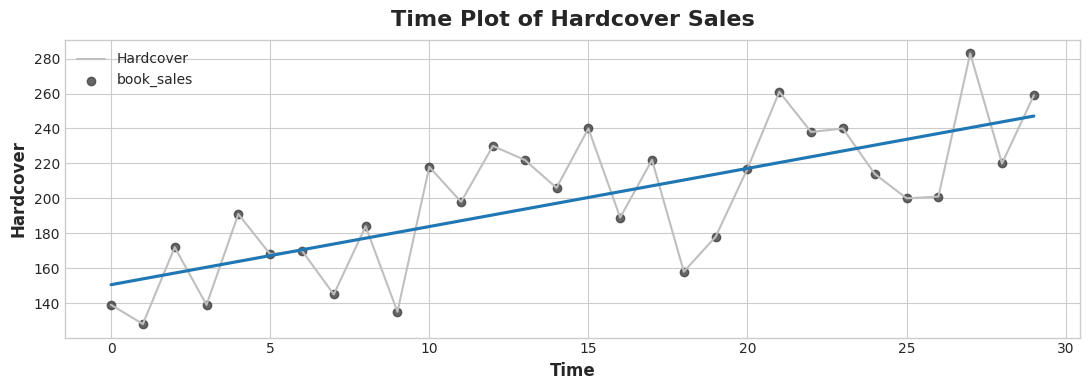

In [50]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'), label='book_sales')
ax.set_title('Time Plot of Hardcover Sales');
ax.legend()
plt.show()

## **Weight & Bias of Linear Regression Model ("book_sales"-dataframe):**

In [43]:
slope, intercept, r_value, p_value, std_err = linregress(x=book_sales['Time'], y=book_sales['Hardcover'])
slope, intercept
print(f'weight "w": {slope}')
print(f'bias "b": {intercept}')

weight "w": 3.3305895439377085
bias "b": 150.53978494623658


## **Interpret linear regression with "time dummy" (book_sales-dataframe):**

The linear regression line has an equation of (approximately) `Hardcover = 3.33 * Time + 150.5`. 

In [52]:
book_sales['Time']= np.arange(len(book_sales.index))
#The slope is 3.33, so Hardcover will change on average by 3.33 units for every 1 step change in Time, according to this model.


-------------------------------------------------------------------------------

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Considering the model `target = weight * lag_1 + error`, where `error` is random noise and `weight` is a number between -1 and 1. The `weight` in this case tells us how likely the next time step will have the same sign as the previous time step: a `weight` close to 1 means `target` will likely have the same sign as the previous step, while a `weight` close to -1 means `target` will likely have the opposite sign.

## **Interpret linear regression with "lag feature" (ar-dataframe):**


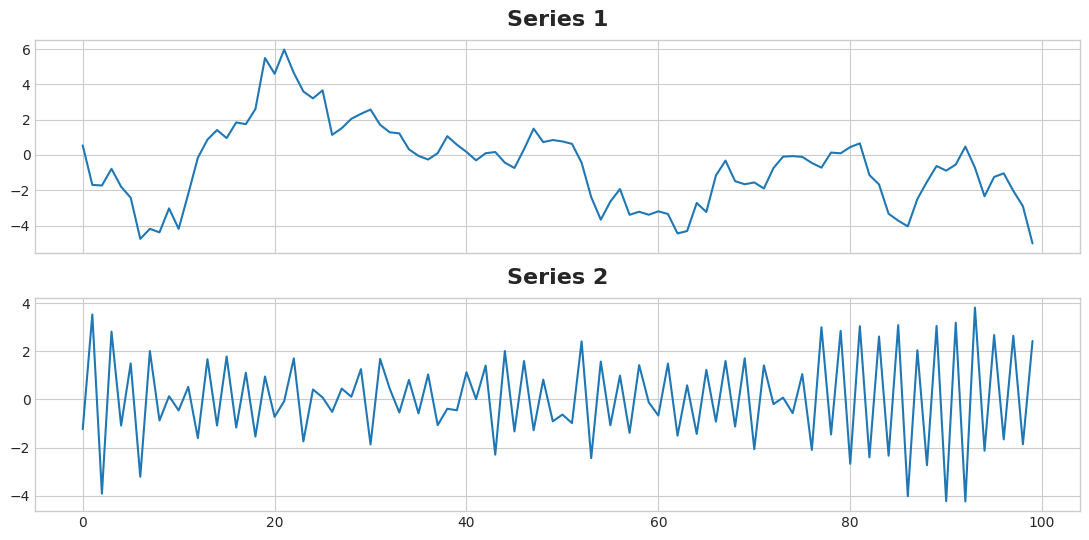

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True) #sharex=True -> both plots share same x-axis
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

Note:
One of these series has the equation `target = 0.95 * lag_1 + error` and the other has the equation `target = -0.95 * lag_1 + error`, differing only by the sign on the lag feature. 

## **Check which Series have negative weight/slope (ar-dataframe)**:

Text(0.5, 1.0, 'Series ar2')

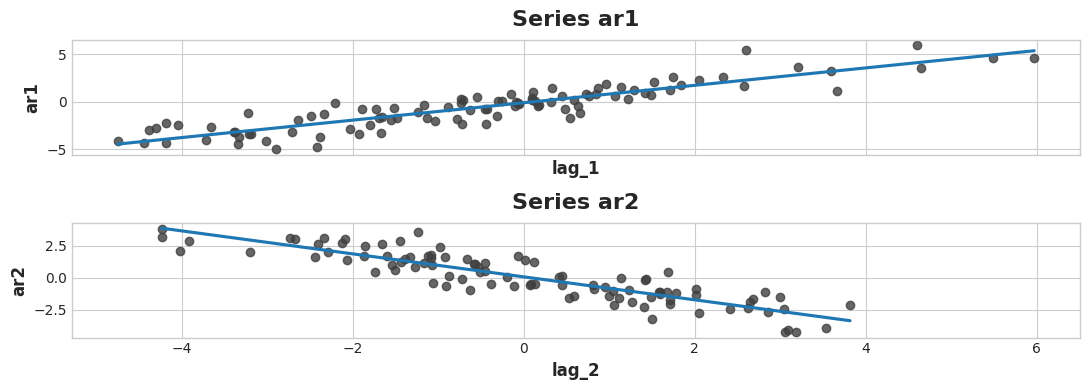

In [53]:
ar['lag_1']=ar['ar1'].shift(1)
ar['lag_2']=ar['ar2'].shift(1)
ar.dropna(inplace=True)
fig,(ax_1,ax_2)=plt.subplots(2,1, sharex=True )
ax_1=sns.regplot(x='lag_1',y='ar1',data=ar, ci=None, scatter_kws=dict(color='0.25'), ax=ax_1)
ax_1.set_title('Series ar1')
ax_2=sns.regplot(x='lag_2',y='ar2', data=ar, ci=None, scatter_kws=dict(color='0.25'), ax=ax_2)
ax_2.set_title('Series ar2')
#Series with the 0.95 weight will tend to have values with signs that stay the same. 
#Series with the -0.95 weight will tend to have values with signs that change back and forth.

In [54]:
#check ar-dataframe with the plot above
ar

,ar1,ar2,lag_1,lag_2
1,-1.692950,3.532498,0.541286,-1.234475
2,-1.730106,-3.915508,-1.692950,3.532498
3,-0.783524,2.820841,-1.730106,-3.915508
4,-1.796207,-1.084120,-0.783524,2.820841
5,-2.420485,1.497753,-1.796207,-1.084120
...,...,...,...,...
95,-1.242355,2.675995,-2.338288,-2.131667
96,-1.042621,-1.658682,-1.242355,2.675995
97,-2.032754,2.647366,-1.042621,-1.658682
98,-2.903010,-1.860723,-2.032754,2.647366


-------------------------------------------------------------------------------

Time Series Forecasting dataset. The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. We have worked with a single series (`average_sales`) of the average sales each day.

## **Fit a time-step feature (store_sales-dataframe):**

Create a linear regression model with a time-step feature on the series of average product sales. The target is in a column called `'sales'`.

In [55]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame() #pd.Series to pd.DataFrame

time = np.arange(len(df.index))

df['time'] = time 

# create training data
X = df.loc[:,['time']]  # features
y = df.loc[:,'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# store the fitted values as a time series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

## **Linear Regression fit (store_sales-dataframe):**

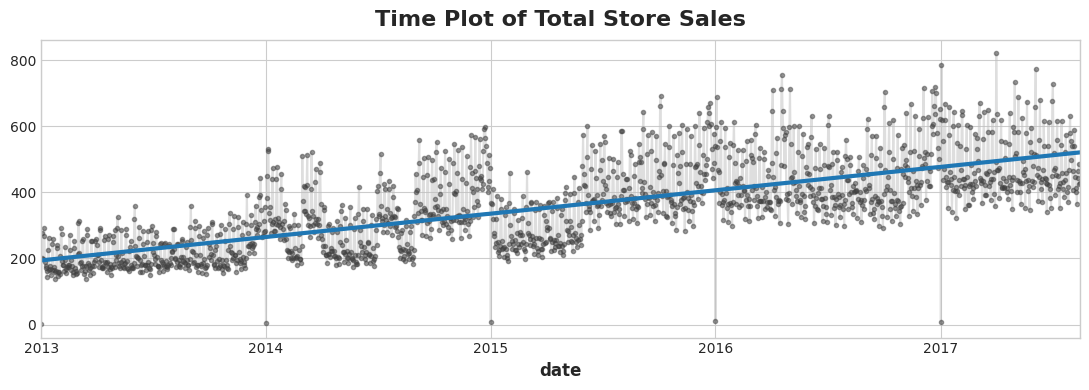

In [37]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

-------------------------------------------------------------------------------

## **Fit a lag feature ("store_sales"-dataframe)**:

Complete the code below to create a linear regression model with a lag feature on the series of average product sales. The target is in a column of `df` called `'sales'`.

In [56]:
df = average_sales.to_frame()

# create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X,y)

# create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

date
2013-01-02     85.301689
2013-01-03    297.268250
2013-01-04    239.451340
2013-01-05    236.444550
2013-01-06    289.219421
                 ...    
2017-08-11    363.958893
2017-08-12    439.106384
2017-08-13    424.615509
2017-08-14    455.968994
2017-08-15    410.998535
Freq: D, Length: 1683, dtype: float32

## **Lag Plot ("store_sales"-dataframe):**

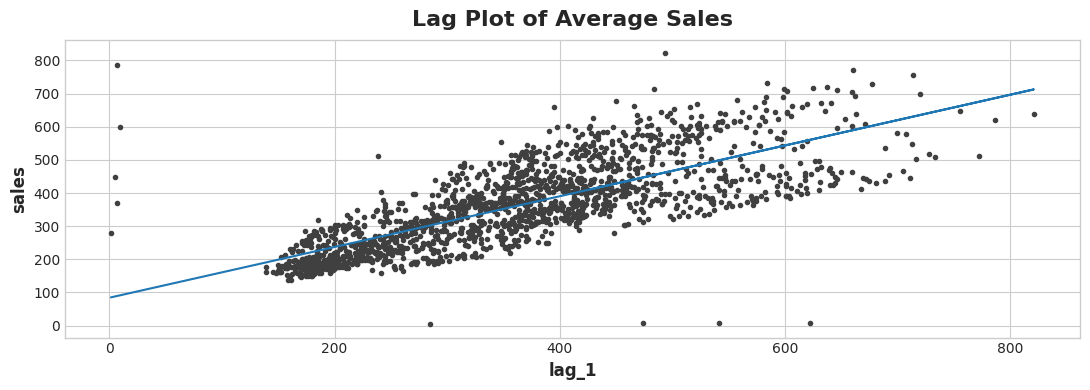

In [57]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');